In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    #total_loss = modulating_number*((1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss)
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss*modulating_number
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0616/weights_KD_segformer_0616_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.7
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should pro

FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - loss: 0.0366

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 800ms/step - loss: 0.0289
Average validation loss: 0.6155844330787659
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 818ms/step - loss: 0.0289 - val_loss: 0.6156
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_5.pth'.
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 805ms/step - loss: 0.0198 - val_loss: 0.6156
Average validation loss: 0.5186117887496948
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 818ms/step - loss: 0.0198 - val_loss: 0.5671
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_5.pth'.
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 822ms/step - loss: 0.0145 - val_loss: 0.5671
Average validation loss: 0.38510340452194214
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 835ms/step - loss: 0.0145 - val_loss: 0.5064
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_se

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 779ms/step - loss: 1.0433e-05
Average validation loss: 0.1452374942600727
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 796ms/step - loss: 1.0433e-05 - val_loss: 0.1452
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_10.pth'.
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 809ms/step - loss: 9.9744e-06 - val_loss: 0.1452
Average validation loss: 0.04313714616000652
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 819ms/step - loss: 9.9744e-06 - val_loss: 0.0942
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_10.pth'.
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 822ms/step - loss: 9.5790e-06 - val_loss: 0.0942
Average validation loss: 0.04226487781852484
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 831ms/step - loss: 9.5790e-06 - val_loss: 0.0769
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 772ms/step - loss: 3.2667e-06
Average validation loss: 0.024611407270034153
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 786ms/step - loss: 3.2667e-06 - val_loss: 0.0246
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_15.pth'.
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 786ms/step - loss: 3.4488e-06 - val_loss: 0.0246
Average validation loss: 0.08988714714845021
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 799ms/step - loss: 3.4488e-06 - val_loss: 0.0572
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 28s 767ms/step - loss: 3.4280e-06 - val_loss: 0.0572
Average validation loss: 0.025157566803197067
12/12 ━━━━━━━━━━━━━━━━━━━━ 29s 782ms/step - loss: 3.4280e-06 - val_loss: 0.0466
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 38s 799ms/step - loss: 3.2449e-06 - val_loss: 0.0466
Average validation loss: 0.016727855429053307
12/12 ━━━━━━━━━━━━━━━━━━━━ 38s 810ms/step - loss: 3.2449e-06 - val_loss: 0.0391
Saved m

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 794ms/step - loss: 2.1260e-06
Average validation loss: 0.011458779103122652
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 807ms/step - loss: 2.1260e-06 - val_loss: 0.0115
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_20.pth'.
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 26s 800ms/step - loss: 1.8759e-06 - val_loss: 0.0115
Average validation loss: 0.007878090837039053
16/16 ━━━━━━━━━━━━━━━━━━━━ 26s 811ms/step - loss: 1.8759e-06 - val_loss: 0.0097
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_20.pth'.
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 793ms/step - loss: 1.7074e-06 - val_loss: 0.0097
Average validation loss: 0.007259711972437799
16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 806ms/step - loss: 1.7074e-06 - val_loss: 0.0089
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 823ms/step - loss: 1.4749e-06
Average validation loss: 0.003800755296833813
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 834ms/step - loss: 1.4749e-06 - val_loss: 0.0038
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_25.pth'.
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 810ms/step - loss: 1.3984e-06 - val_loss: 0.0038
Average validation loss: 0.021495276223868133
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 820ms/step - loss: 1.3984e-06 - val_loss: 0.0126
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 50s 811ms/step - loss: 1.2586e-06 - val_loss: 0.0126
Average validation loss: 0.0051477191969752315
20/20 ━━━━━━━━━━━━━━━━━━━━ 50s 822ms/step - loss: 1.2586e-06 - val_loss: 0.0101
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 66s 808ms/step - loss: 1.1225e-06 - val_loss: 0.0101
Average validation loss: 0.003333007264882326
20/20 ━━━━━━━━━━━━━━━━━━━━ 66s 818ms/step - loss: 1.1225e-06 - val_loss: 0.0084
Save

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 814ms/step - loss: 9.7266e-07
Average validation loss: 0.0038868951766441264
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 824ms/step - loss: 9.7266e-07 - val_loss: 0.0039
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_30.pth'.
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 39s 807ms/step - loss: 7.9893e-07 - val_loss: 0.0039
Average validation loss: 0.00455719546880573
24/24 ━━━━━━━━━━━━━━━━━━━━ 39s 817ms/step - loss: 7.9893e-07 - val_loss: 0.0042
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 59s 806ms/step - loss: 6.8550e-07 - val_loss: 0.0042
Average validation loss: 0.004246131555798153
24/24 ━━━━━━━━━━━━━━━━━━━━ 59s 816ms/step - loss: 6.8550e-07 - val_loss: 0.0042
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 78s 806ms/step - loss: 5.9749e-07 - val_loss: 0.0042
Average validation loss: 0.00371202405464525
24/24 ━━━━━━━━━━━━━━━━━━━━ 79s 816ms/step - loss: 5.9749e-07 - val_loss: 0.0041
Saved 

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 35s 867ms/step - loss: 2.3385e-06
Average validation loss: 0.0391070468001999
40/40 ━━━━━━━━━━━━━━━━━━━━ 35s 880ms/step - loss: 2.3385e-06 - val_loss: 0.0391
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_50.pth'.
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 68s 815ms/step - loss: 1.9282e-06 - val_loss: 0.0391
Average validation loss: 0.026821386336814614
40/40 ━━━━━━━━━━━━━━━━━━━━ 68s 828ms/step - loss: 1.9282e-06 - val_loss: 0.0330
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_50.pth'.
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 100s 803ms/step - loss: 1.5644e-06 - val_loss: 0.0330
Average validation loss: 0.016774531034752727
40/40 ━━━━━━━━━━━━━━━━━━━━ 101s 816ms/step - loss: 1.5644e-06 - val_loss: 0.0276
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 40s 837ms/step - loss: 5.8069e-06
Average validation loss: 0.029322447255253792
48/48 ━━━━━━━━━━━━━━━━━━━━ 41s 849ms/step - loss: 5.8069e-06 - val_loss: 0.0293
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_60.pth'.
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 81s 831ms/step - loss: 5.4775e-06 - val_loss: 0.0293
Average validation loss: 0.2136135995388031
48/48 ━━━━━━━━━━━━━━━━━━━━ 81s 843ms/step - loss: 5.4775e-06 - val_loss: 0.1215
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 121s 832ms/step - loss: 5.4830e-06 - val_loss: 0.1215
Average validation loss: 0.06984715908765793
48/48 ━━━━━━━━━━━━━━━━━━━━ 122s 844ms/step - loss: 5.4830e-06 - val_loss: 0.1043
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 162s 831ms/step - loss: 5.8532e-06 - val_loss: 0.1043
Average validation loss: 0.030092285480350256
48/48 ━━━━━━━━━━━━━━━━━━━━ 162s 843ms/step - loss: 5.8532e-06 - val_loss: 0.0857
Epoc

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 44s 793ms/step - loss: 2.7261e-06
Average validation loss: 0.009717825883334237
56/56 ━━━━━━━━━━━━━━━━━━━━ 45s 805ms/step - loss: 2.7261e-06 - val_loss: 0.0097
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_70.pth'.
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 90s 797ms/step - loss: 2.6816e-06 - val_loss: 0.0097
Average validation loss: 0.03996267242889319
56/56 ━━━━━━━━━━━━━━━━━━━━ 90s 809ms/step - loss: 2.6816e-06 - val_loss: 0.0248
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 137s 827ms/step - loss: 2.7648e-06 - val_loss: 0.0248
Average validation loss: 0.014002576054606055
56/56 ━━━━━━━━━━━━━━━━━━━━ 137s 838ms/step - loss: 2.7648e-06 - val_loss: 0.0212
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 182s 806ms/step - loss: 2.4891e-06 - val_loss: 0.0212
Average validation loss: 0.008667210865366672
56/56 ━━━━━━━━━━━━━━━━━━━━ 183s 818ms/step - loss: 2.4891e-06 - val_loss: 0.0181
Sa

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 50s 778ms/step - loss: 1.2527e-06
Average validation loss: 0.007023843354545534
64/64 ━━━━━━━━━━━━━━━━━━━━ 51s 790ms/step - loss: 1.2527e-06 - val_loss: 0.0070
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_80.pth'.
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 100s 777ms/step - loss: 9.3553e-07 - val_loss: 0.0070
Average validation loss: 0.0063506028964184225
64/64 ━━━━━━━━━━━━━━━━━━━━ 101s 788ms/step - loss: 9.3553e-07 - val_loss: 0.0067
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_80.pth'.
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 151s 778ms/step - loss: 7.7099e-07 - val_loss: 0.0067
Average validation loss: 0.0075053915061289445
64/64 ━━━━━━━━━━━━━━━━━━━━ 152s 789ms/step - loss: 7.7099e-07 - val_loss: 0.0070
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 201s 774ms/step - los

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 56s 772ms/step - loss: 9.4588e-07
Average validation loss: 0.011786893191229966
72/72 ━━━━━━━━━━━━━━━━━━━━ 56s 784ms/step - loss: 9.4588e-07 - val_loss: 0.0118
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_90.pth'.
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 112s 776ms/step - loss: 7.3126e-07 - val_loss: 0.0118
Average validation loss: 0.009403998019277222
72/72 ━━━━━━━━━━━━━━━━━━━━ 113s 786ms/step - loss: 7.3126e-07 - val_loss: 0.0106
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_90.pth'.
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 169s 779ms/step - loss: 5.9576e-07 - val_loss: 0.0106
Average validation loss: 0.00750991421389497
72/72 ━━━━━━━━━━━━━━━━━━━━ 170s 790ms/step - loss: 5.9576e-07 - val_loss: 0.0096
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 62s 774ms/step - loss: 6.6088e-07
Average validation loss: 0.008377134928014129
80/80 ━━━━━━━━━━━━━━━━━━━━ 63s 784ms/step - loss: 6.6088e-07 - val_loss: 0.0084
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_100.pth'.
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 125s 774ms/step - loss: 4.8550e-07 - val_loss: 0.0084
Average validation loss: 0.006049091421300545
80/80 ━━━━━━━━━━━━━━━━━━━━ 126s 784ms/step - loss: 4.8550e-07 - val_loss: 0.0072
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_100.pth'.
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 194s 851ms/step - loss: 4.0052e-07 - val_loss: 0.0072
Average validation loss: 0.01295968034537509
80/80 ━━━━━━━━━━━━━━━━━━━━ 195s 862ms/step - loss: 4.0052e-07 - val_loss: 0.0091
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 257s 782ms/step - loss

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 75s 779ms/step - loss: 5.9173e-06
Average validation loss: 0.013574138681481903
96/96 ━━━━━━━━━━━━━━━━━━━━ 76s 790ms/step - loss: 5.9173e-06 - val_loss: 0.0136
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_120.pth'.
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 150s 773ms/step - loss: 4.1248e-06 - val_loss: 0.0136
Average validation loss: 0.01377433945890516
96/96 ━━━━━━━━━━━━━━━━━━━━ 151s 785ms/step - loss: 4.1248e-06 - val_loss: 0.0137
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 225s 772ms/step - loss: 2.9945e-06 - val_loss: 0.0137
Average validation loss: 0.0188650666968897
96/96 ━━━━━━━━━━━━━━━━━━━━ 226s 784ms/step - loss: 2.9945e-06 - val_loss: 0.0154
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 300s 766ms/step - loss: 2.3751e-06 - val_loss: 0.0154
Average validation loss: 0.01617341990155789
96/96 ━━━━━━━━━━━━━━━━━━━━ 301s 776ms/step - loss: 2.3751e-06 - val_loss: 0.0156
Ep

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 ━━━━━━━━━━━━━━━━━━━━ 94s 782ms/step - loss: 2.6187e-06
Average validation loss: 0.008864263771101832
120/120 ━━━━━━━━━━━━━━━━━━━━ 95s 793ms/step - loss: 2.6187e-06 - val_loss: 0.0089
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_150.pth'.
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 189s 780ms/step - loss: 1.6260e-06 - val_loss: 0.0089
Average validation loss: 0.025340150079379477
120/120 ━━━━━━━━━━━━━━━━━━━━ 190s 791ms/step - loss: 1.6260e-06 - val_loss: 0.0171
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 283s 775ms/step - loss: 1.2446e-06 - val_loss: 0.0171
Average validation loss: 0.00791839687153697
120/120 ━━━━━━━━━━━━━━━━━━━━ 285s 786ms/step - loss: 1.2446e-06 - val_loss: 0.0140
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_150.pth'.
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 379s 782

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 112s 774ms/step - loss: 7.4368e-06
Average validation loss: 0.08082056262840827
144/144 ━━━━━━━━━━━━━━━━━━━━ 113s 785ms/step - loss: 7.4368e-06 - val_loss: 0.0808
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_180.pth'.
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 224s 772ms/step - loss: 6.2315e-06 - val_loss: 0.0808
Average validation loss: 0.019327965694376163
144/144 ━━━━━━━━━━━━━━━━━━━━ 226s 783ms/step - loss: 6.2315e-06 - val_loss: 0.0501
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_180.pth'.
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 337s 772ms/step - loss: 5.1735e-06 - val_loss: 0.0501
Average validation loss: 0.01290195386779184
144/144 ━━━━━━━━━━━━━━━━━━━━ 339s 783ms/step - loss: 5.1735e-06 - val_loss: 0.0377
Saved model weights to 'c:\天_11157065\git\Rippl

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 ━━━━━━━━━━━━━━━━━━━━ 123s 771ms/step - loss: 1.8709e-06
Average validation loss: 0.009923147637164221
160/160 ━━━━━━━━━━━━━━━━━━━━ 125s 782ms/step - loss: 1.8709e-06 - val_loss: 0.0099
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_200.pth'.
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 256s 815ms/step - loss: 1.3404e-06 - val_loss: 0.0099
Average validation loss: 0.013450796998222358
160/160 ━━━━━━━━━━━━━━━━━━━━ 257s 826ms/step - loss: 1.3404e-06 - val_loss: 0.0117
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 382s 781ms/step - loss: 1.0914e-06 - val_loss: 0.0117
Average validation loss: 0.009590474551077931
160/160 ━━━━━━━━━━━━━━━━━━━━ 384s 791ms/step - loss: 1.0914e-06 - val_loss: 0.0110
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_200.pth'.
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 510s 

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 154s 772ms/step - loss: 5.5628e-06
Average validation loss: 0.012345756036229432
200/200 ━━━━━━━━━━━━━━━━━━━━ 156s 783ms/step - loss: 5.5628e-06 - val_loss: 0.0123
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_250.pth'.
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 313s 782ms/step - loss: 3.4681e-06 - val_loss: 0.0123
Average validation loss: 0.030496096235729055
200/200 ━━━━━━━━━━━━━━━━━━━━ 315s 793ms/step - loss: 3.4681e-06 - val_loss: 0.0214
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 469s 772ms/step - loss: 2.7384e-06 - val_loss: 0.0214
Average validation loss: 0.01367931452114135
200/200 ━━━━━━━━━━━━━━━━━━━━ 472s 783ms/step - loss: 2.7384e-06 - val_loss: 0.0188
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 628s 781ms/step - loss: 2.2261e-06 - val_loss: 0.0188
Average validation loss: 0.01562692445855646
200/200 ━━━━━━━━━━━━━━━━━━━━ 630s 792ms/step - loss: 2.2261e-06 -

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 ━━━━━━━━━━━━━━━━━━━━ 185s 773ms/step - loss: 1.2979e-06
Average validation loss: 0.016207363505479102
240/240 ━━━━━━━━━━━━━━━━━━━━ 188s 783ms/step - loss: 1.2979e-06 - val_loss: 0.0162
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_300.pth'.
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 373s 769ms/step - loss: 9.4762e-07 - val_loss: 0.0162
Average validation loss: 0.012238752703221204
240/240 ━━━━━━━━━━━━━━━━━━━━ 375s 780ms/step - loss: 9.4762e-07 - val_loss: 0.0142
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_70\segformer_data_size_300.pth'.
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 560s 771ms/step - loss: 7.6869e-07 - val_loss: 0.0142
Average validation loss: 0.012885956805257592
240/240 ━━━━━━━━━━━━━━━━━━━━ 563s 782ms/step - loss: 7.6869e-07 - val_loss: 0.0138
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 747s 

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.1362321550026536, 0.05410448986571282, 0.018940124873382348, 0.008795777641353197, 0.006517922700848431, 0.005301302455094022, 0.06419183247257024, 0.03892560600031478, 0.011842397583781606, 0.018148972277558642, 0.010380842063912295, 0.007958767692791297, 0.015504817275796086, 0.013043673101672766, 0.014970929178589863, 0.014716640018839005, 0.01706930366874678, 0.010416432409267902]
std_val_losses =  [0.11701361210627811, 0.04127949333650618, 0.02274049256562168, 0.006056782425230255, 0.004218154764213357, 0.0021576779631494744, 0.11457704113814325, 0.04448704199806764, 0.005755471640422159, 0.014460578514895838, 0.0046423322729749784, 0.0028784736617915568, 0.015818381749679013, 0.009218628500451987, 0.011336569467184362, 0.009049051015260295, 0.0076608097131528365, 0.0017715900134036237]


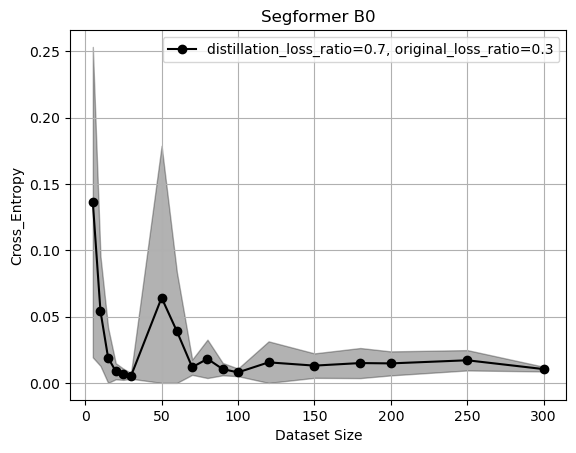

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0616')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0616_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0616_{int(teacher_ratio*100)}.png"))

plt.show()